In [1]:
import pandas as pd
import networkx as nx
import bqplot.pyplot as plt
%matplotlib inline

In [2]:
data_bilan=pd.read_csv("is_bilan.csv",sep=";")

In [3]:
data_bilan["IS_BILAN"]=data_bilan["IS_BILAN"].apply(lambda x: "BILAN" if x ==1 else "EPIDEMIE")

# Analyse de la structure des STRs avec un cas d'étude : Bilan/Récapitulatif d'une épidémie

**La spatialité s'exprime-t-elle de la même manière dans certaines classes ou types de document ?** Dans le domaine de surveillance d'épidémies animales utilisant Google News, les chercheurs ont besoin de différencier un récapitulatif/bilan de la situation concernant une épidémie et la déclaration de celle-ci. Dans cette expérimentation, nous allons essayer de voir si ces deux classes de documents possèdent des caractéristiques spécifiques au travers de la STR.


## Définition des deux classes

À l'aide du corpus de PadiWeb, on selectionne un échantillon de 100 documents que l'on divise en deux classes:

  * **Bilan**. Un récapitulatif d'un événement terminé ou en cours.
  * **Épidémie**. Son but est d'annoncer le déclenchment d'une épidémie (le point de départ).

L'effectif de chacune des classes est indiqué ci-dessous.

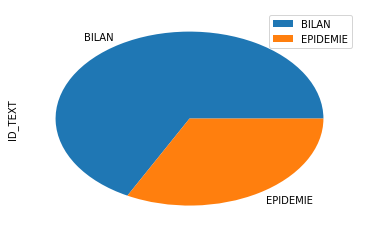

In [4]:
data_bilan.groupby("IS_BILAN").count().plot.pie("ID_TEXT")

In [5]:
import numpy as np
def number_of_edges(x,color=None):
    """
    Dedicated function to count edges based on their color
    """
    if not color:
        return len(x.number_of_edges())
    edges=list(x.edges(data=True))
    cp=0
    for ed in edges:
        if ed[-1]["color"] == color:
            cp+=1
    return cp


def flattern(A):
    rt = []
    for i in A:
        if isinstance(i, list):
            rt.extend(flattern(i))
        elif isinstance(i, np.ndarray):
            rt.extend(flattern(i.tolist()))
        else:
            rt.append(i)
    return rt
def most_common(lst):
    if not lst:
        return "P-PPL"
    if len(list(set(lst))) >1 and "P-PPL" in set(lst):
        lst=[x for x in lst if x != "PPL"]
    return max(set(lst), key=lst.count)



In [6]:
import nxpd
nxpd.nxpdParams["show"]="ipynb"
from strpython.helpers.gazeteer_helpers import get_data
def class_graph(g):
    mapping={}
    g2=g.copy()
    for n in g2:
        c=get_data(n)["class"]
        g2.nodes[n]["label"]=most_common(c)
    return g2

Pour faire une comparaison entre les STRs générées dans chaque classe de document, on utilise plusieurs indicateurs :

 * **Granularité** La granularité est définie le niveau dans l'échelle spatiale ($village$ < $ville < pays$) d'une entité. Ici, elle nous indique à quel niveau la spatialité est utilisé pour décrire la situation.
 * **Densité** La densité est définie par le nombre d'arêtes moyen pour un noeud dans un graphe. Un graphe d'une STR avec une forte densité, indique une forte cohésion entre les entités spatiales.
 * **Ratio $Relation_i/Relation_j$** Dans la STR, chaque entité peut-être reliée à une autre par deux type de relations : inclusion et adjacence. Avec ce ratio, on souhaite savoir combien il existe de $relation_j$ pour une $relation_i$. Par exemple, pour une relation d'inclusion, combien de relations d'adjacence ?
 * **Nombre de noeuds(entités spatiales)** Indique si des textes sont fortement spatialisés.


### Calcul de la granularité d'une STR

On récupére les **classes associées** aux différentes **entités de la STR**, puis on récupére **la classe la plus fréquente**. Par exemple:

$STR_1$ --> France, Montpellier, Clapiers, Caen --> [A-PCLI], [P-PPL, A-ADM4], [A-ADM4], [A-ADM4]

On a donc pour granularité : **A-ADM4**

### Calcul de la densité d'une STR
Le calcul de la densité d'une STR (ici son graphe) se calcule à l'aide de la formule suivante : $$\frac{2\times|E|}{|V|\times(|V|-1)}$$



In [7]:
data_bilan["GRAPH"]=data_bilan["ID_TEXT"].apply(lambda x:nx.read_gexf("str_PADI100/{0}.gexf".format(x)))
data_bilan["GRAPH_C"]=data_bilan["GRAPH"].apply(lambda x:class_graph(x))

In [8]:
data_bilan["DENSITY"]=data_bilan["GRAPH"].apply(lambda x: (2*x.number_of_edges())/(x.number_of_nodes()*(x.number_of_nodes()-1)) if len(x) >1 else 0)
data_bilan["NB_NODE"]=data_bilan["GRAPH"].apply(lambda x: len(x))
data_bilan["NB_ED_ADJ"]=data_bilan["GRAPH"].apply(lambda x: number_of_edges(x,color="green")/2)
data_bilan["NB_ED_INC"]=data_bilan["GRAPH"].apply(lambda x: number_of_edges(x,color="red"))
data_bilan["R_ADJ_INC"]=((data_bilan["NB_ED_ADJ"])/data_bilan["NB_ED_INC"]).replace([np.inf, -np.inf], np.nan).fillna(0)
data_bilan["R_INC_ADJ"]=(data_bilan["NB_ED_INC"]/(data_bilan["NB_ED_ADJ"])).replace([np.inf, -np.inf], np.nan).fillna(0)

In [9]:
data_bilan["CLASS"]=data_bilan["GRAPH"].apply(lambda x: flattern([get_data(n)["class"] for n in list(x.nodes())]))
data_bilan["MEAN_LVL"]=data_bilan["CLASS"].apply(lambda x: most_common(x) if len(x)>0 else "")

In [10]:
data_bilan.head(9)

ID_TEXT  IS_BILAN  MIXED  \
0        0     BILAN      0   
1        1  EPIDEMIE      0   
2        2     BILAN      1   
3        3     BILAN      0   
4        4  EPIDEMIE      0   
5        5  EPIDEMIE      1   
6        6  EPIDEMIE      0   
7        7     BILAN      0   
8        8     BILAN      0   

                                               GRAPH  \
0          (GD4103071, GD4468122, GD95073, GD791183)   
1                                        (GD1685421)   
2                                        (GD2032795)   
3                             (GD1626932, GD3274230)   
4        (GD639917, GD3789919, GD1316637, GD2055944)   
5  (GD639917, GD3995806, GD3789919, GD1316637, GD...   
6                   (GD639917, GD3789919, GD2055944)   
7        (GD5526704, GD976842, GD1316637, GD2055944)   
8  (GD2908705, GD1404948, GD9642903, GD3995806, G...   

                                             GRAPH_C   DENSITY  NB_NODE  \
0          (GD4103071, GD4468122, GD95073, GD791183)  0.000000        4   
1                                        (GD1685421)  0.000000        1   
2                                        (GD2032795)  0.000000        1   
3                             (GD1626932, GD3274230)  0.000000        2   
4        (GD639917, GD3789919, GD1316637, GD2055944)  0.166667        4   
5  (GD639917, GD3995806, GD3789919, GD1316637, GD...  0.200000        5   
6                   (GD639917, GD3789919, GD2055944)  0.000000        3   
7        (GD5526704, GD976842, GD1316637, GD2055944)  0.333333        4   
8  (GD2908705, GD1404948, GD9642903, GD3995806, G...  0.285714        7   

   NB_ED_ADJ  NB_ED_INC  R_ADJ_INC  R_INC_ADJ  \
0        0.0          0        0.0        0.0   
1        0.0          0        0.0        0.0   
2        0.0          0        0.0        0.0   
3        0.0          0        0.0        0.0   
4        0.0          1        0.0        0.0   
5        0.0          2        0.0        0.0   
6        0.0          0        0.0        0.0   
7        1.0          0        0.0        0.0   
8        2.0          2        1.0        1.0   

                                               CLASS MEAN_LVL  
0            [P-PPLA, P-PPL, P-PPLA, A-ADM1, P-PPLA]   P-PPLA  
1                                            [P-PPL]    P-PPL  
2                                           [A-PCLI]   A-PCLI  
3                                    [A-PCLI, P-PPL]   A-PCLI  
4   [A-PCLI, A-ADM1, P-PPLA, P-PPLC, A-PCLI, A-PCLI]   A-PCLI  
5  [A-PCLI, P-PPL, A-ADM1, P-PPLA, P-PPLC, A-PCLI...   A-PCLI  
6           [A-PCLI, A-ADM1, P-PPLA, P-PPLC, A-PCLI]   A-PCLI  
7                   [A-PCLI, A-PCLI, A-PCLI, A-PCLI]   A-PCLI  
8  [A-ADM1, P-PPL, P-PPL, P-PPL, A-ADM1, A-ADM1, ...    P-PPL

# Résultats

### Granularité sur les documents de classe **BILAN**

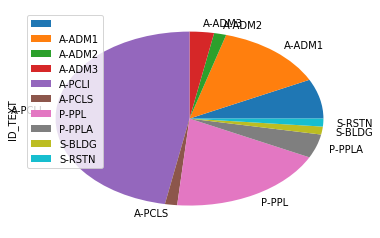

In [11]:
data_bilan[data_bilan["IS_BILAN"] == "BILAN"].groupby("MEAN_LVL").count().plot.pie("ID_TEXT")

### Granularité sur les documents de classe **EPIDEMIE**

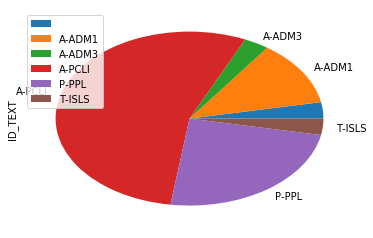

In [12]:
data_bilan[data_bilan["IS_BILAN"] == "EPIDEMIE"].groupby("MEAN_LVL").count().plot.pie("ID_TEXT")

### Valeurs moyennes obtenues pour chaque indicateur

In [13]:
data_bilan.groupby("IS_BILAN").mean()

ID_TEXT     MIXED   DENSITY   NB_NODE  NB_ED_ADJ  NB_ED_INC  \
IS_BILAN                                                                  
BILAN     51.588235  0.014706  0.293545  6.455882   2.058824   2.705882   
EPIDEMIE  46.727273  0.030303  0.379501  4.636364   1.484848   1.303030   

          R_ADJ_INC  R_INC_ADJ  
IS_BILAN                        
BILAN      0.559194   1.049048  
EPIDEMIE   0.398990   0.240657

## Analyse des résultats


### Granularité

En regardant les deux camemberts ci-dessus, on remarque que la granularité observé dans les STRs différe selon le type de texte. Les textes de classe **épidémie** sont généralement plus "haut" dans la hiérarchie spatiale, de part la forte présence de classe telles que: A-PCLI ($\approx$Pays), A-ADM1(premier découpage administratif d'un pays *equiv* région en France, état aux Etats-Unis, *etc.*). Ceux de la classe **BILAN**, ont une granularité un peu plus fine avec un spectre de classe plus étendue : T-ISL (ile), S-BLDG (batiment).

En se basant sur la classification proposé, on conclue que les documents de type **bilan** sont plus "fin" spatialement que ceux de la classe **épidémie**. 

### Densité/ Nombre de noeuds/ Nombre d'arrêtes

Malheuresement la densité moyenne ne permet de faire aucune conclusion.

On observe que le nombre de noeuds dans les documents de classes Bilan est plus élevé. Ce qui indique que le nombre d'entités spatiales dans ces documents est plus élevés. Ce qui semble tout à fait normal car contrairement à une déclaration d'épidémie, le bilan fait un récapitulatif de la propagation d'une maladie sur un laps de temps et une spatialité (souvent) plus importante.

Pour le nombre de relations d'ajacence et d'inclusion, on observe un même rapport de "force" : Il y a plus d'arêtes d'inclusion que d'arêtes d'adjacence.

### Ratio Adjacence/Inclusion VS Inclusion/Adjacence

| CLASSE   | ADJ/INC  | INC/ADJ  |
|----------|----------|----------|
| BILAN    | 0.559194 | 1.04905  |
| EPIDEMIE | 0.39899  | 0.240657 |

On reprend les résultats concernat les rapports ADJ/INC (combien de relations d'inclusion pour une relation d'adjacence ?) et INC/ADJ (le contraire de ADJ/INC). A partir de ces résultats, on observe que les rapports sont inversés ! Pour les documents de classe EPIDEMIE, on va favoriser plus les relations d'inclusion, contrairement aux documents de classe BILAN qui favorisent les relations d'adjacences.

Est-ce que parce que les relations d'inclusions sont favorisés (ratio ADJ/INC élevé), on se retrouve sur des zones limitées, donc plus local ? Ca rentre bien dans le cadre de la classe épidémie.

Est-ce qu'un ratio élevé INC/ADJ traduit une information concernant la dispertion d'une maladie ? 
